### NAO correlations with energy variables ###

Exploring how well the NAO correlates with energy variables on seasonal to decadal timescales during the winter (ONDJFM, DJFM, or DJF). Using the following datasets:

* CLEARHEADS - ERA5-derived energy time series, includes offshore wind in EEZs and Heating Degree Days.
* ERA5 - reanalysis product for deriving the NAO indices at different timescales.
* ENTSO-E - shorter observed time series of capacity factors and other energy variables. For ground truthing the CLEARHEADS data above.

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
import xesmf as xe
from datetime import datetime
from tqdm import tqdm
from scipy.stats import pearsonr

In [2]:
# Import the local functions
import functions_em as funcs_em

In [3]:
sys.path.append("/home/users/benhutch/energy-met-corr")
import dictionaries_em as dicts

sys.path.append("/home/users/benhutch/skill-maps/python")
import functions as fnc

### Testing scatter functions ###

In [4]:
#/gws/nopw/j04/canari/users/benhutch/alternate-lag-processed-data/tas_ONDJFM_global_1961_2014_2-9_4_20_1709338673.215247_nao_matched_members.npy


# Dictionary for predictor var
pred_var_dict = {
    "lag": 4,
    "alt_lag": "nao_matched",
    "method": "nao_matched",
    "region": "global",
}

In [5]:
# test the function for loading the scatter data
dict = funcs_em.process_data_for_scatter(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1961,
    end_year=2014,
    predictor_var="nao",
    predictor_var_dict=pred_var_dict,
    predictand_var="pr",
    predictand_var_file=dicts.regrid_file,
    region=dicts.uk_grid,
    region_name="uk",
)

The region is a dictionary.
Extracting the lats and lons from the region dictionary.
The predictor variable is the NAO index.
Extracting the NAO index from the predictor variable file.
More than one file found
Using the latest datetime file: /gws/nopw/j04/canari/users/benhutch/alternate-lag-processed-data/psl_ONDJFM_global_1964_2014_2-9_4_1708533939.5692165_alternate_lag.npy


Shape of the data: (51, 712, 72, 144)
Using standard NAO definition
Forecast range obs: 2-9


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


obs_anoms.shape = (51,)
data.shape = (20, 51, 72, 144)
obs_anoms.shape = (51,)
len valid_years = 51
modified model data.shape = (20, 51, 72, 144)
model data members.shape = (20, 51)


In [6]:
# Loop over dict and print the keys
for key in dict.keys():
    print(key)

predictor_var
predictand_var
season
forecast_range
start_year
end_year
quantiles
region
predictor_var_ts
predictand_var_ts
predictor_var_mean
predictand_var_mean
rval
pval
slope
intercept
std_err
first_quantile_0.75
second_quantile_0.95
init_years
valid_years
nens
ts_corr
ts_pval
ts_rpc
ts_rps
lag
gridbox
gridbox_name
method


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


First quantile:  0.010765595654573131
Second quantile:  0.018583740311688635


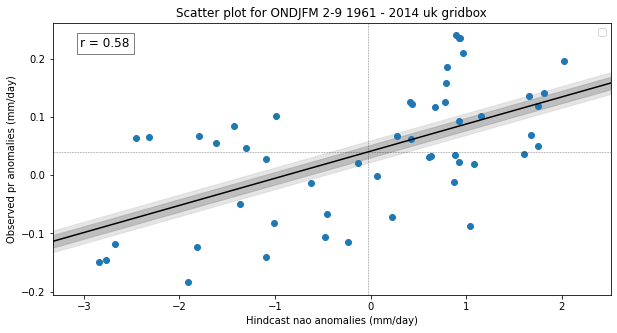

In [7]:
# Plot the scatter data
funcs_em.plot_scatter(
    scatter_dict=dict,  
)

### Downloading ERA5 data ###

For calculating the NAO index, we want to query the CDS API for ERA5 data:

* From 1950-2023
* For ONDJFM
* Monthly-means

*Note - this data should be regridded before comparison with the CLEARHEADS/ENTSO-E data*

In [ ]:
# # Set up a new client
# c = cdsapi.Client()

In [ ]:
# # Set up the dictionary for the ERA5 request
# era5_request_dict = {
#     'variable': 'mean_sea_level_pressure',
#     'product_type': 'monthly_averaged_reanalysis',
#     'year': [x for x in map(str, range(1950, 2023))],
#     'month': [1, 2, 3, 10, 11, 12],
#     'format': 'netcdf',
#     'time': '00:00'
# }

# # Print the request dictionary
# print(era5_request_dict)

In [ ]:
# # Set up the target directory
# target_dir = '/gws/nopw/j04/canari/users/benhutch/ERA5'

# # Assert that the target directory exists
# assert os.path.exists(target_dir)

# # Assert that the target directory is not empty
# assert len(os.listdir(target_dir)) > 0

# # Set up the target file
# target_file = os.path.join(target_dir, 'era5_mslp_monthly_1950_2022_ONDJFM.nc')

# # Print the target file
# print(target_file)

# # If the target file does not exist, download the data
# if not os.path.exists(target_file):
#     c.retrieve(
#         'reanalysis-era5-single-levels',
#         era5_request_dict,
#         target_file)
# else:
#     print('The target file already exists: {}'.format(target_file))

Now we want to plot the observed spatial correlations between the NAO and 10m wind speeds and precipitation.

In [ ]:
# Test this function
stats_dict = funcs_em.calc_nao_spatial_corr(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1960,
    end_year=2014,
    corr_var="pr",
)

In [ ]:
# Extract the nao index
nao = stats_dict["nao"]

# Extract the corr var anomalies
corr_var_ts = stats_dict["corr_var_ts"]

In [ ]:
# Plot the nao index
plt.plot(nao)

In [ ]:
# Create an empty array with the correct shape
corr_array = np.empty([corr_var_ts.shape[1], # lat
                          corr_var_ts.shape[2]]) # lon

# Same for the p-values
pval_array = np.empty([corr_var_ts.shape[1], # lat
                          corr_var_ts.shape[2]]) # lon

# Loop over the lats
for lat in tqdm(range(corr_var_ts.shape[1])):
    # Loop over the lons
    for lon in range(corr_var_ts.shape[2]):
         # Extract the corr_var_ts for the lat and lon
         corr_var_anom_values_lat_lon = corr_var_ts[:, lat, lon]

         # Replace NaNs with 0
         corr_var_anom_values_lat_lon = np.nan_to_num(corr_var_anom_values_lat_lon, nan=0)

         # Calculate the correlation
         corr, pval = pearsonr(nao, corr_var_anom_values_lat_lon)

         # Assign the correlation to the array
         corr_array[lat, lon] = corr

         # Assign the p-value to the array
         pval_array[lat, lon] = pval

# Print the shape of the corr_array
print("shape of corr_array: ", corr_array.shape)
print("shape of pval_array: ", pval_array.shape)

In [ ]:
# Test the function
funcs_em.plot_corr(
    corr_array=corr_array,
    pval_array=pval_array,
    lats=stats_dict["lats"],
    lons=stats_dict["lons"],
    sig_threshold=0.05
)